# Kaggle Competition: House Prices: Advanced Regression Techniques
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
## Part 1: Machine Learning
### Outline:
1. Preparation
2. Testing and Selecting Base Models
3. Finetuning of the Best Model
4. Comparison with simple DLN

In [11]:
# Preparation: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from kaggle_scorer import rmsle

In [12]:
# Preparation: Import processed dataset
path = 'train_processed.csv'
df = pd.read_csv(path, index_col='Id')

df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,12.247694
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,12.109011
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,12.317167
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849398
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,12.429216


In [13]:
# Preparation: Split the dataset in train and test data
X = np.array(df.drop('SalePrice_log',axis=1))
y = np.array(df.loc[:,'SalePrice_log'])

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.6,shuffle=True)

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
# Preparation: Prepare Pipelines
poly_fit = PolynomialFeatures(degree=2)
encoder = OneHotEncoder(handle_unknown='ignore')
norm = Normalizer()
scaler = StandardScaler(with_mean=False)

lin_reg = LinearRegression()
rand_for = RandomForestRegressor()
ada_boost = AdaBoostRegressor()
grad_boost = GradientBoostingRegressor()

lin_pipe = Pipeline([('OneHotEncoder',encoder),
                     ('Normalizer',norm),
                     ('StandardScaler',scaler),
                     ('LinearRegression',lin_reg)])

rand_for_pipe = Pipeline([('OneHotEncoder',encoder),
                          ('Normalizer',norm),
                          ('StandardScaler',scaler),
                          ('RandomForest',rand_for)])

ada_boost_pipe = Pipeline([('OneHotEncoder',encoder),
                           ('Normalizer',norm),
                           ('StandardScaler',scaler),
                           ('AdaBoost',ada_boost)])

grad_boost_pipe = Pipeline([('OneHotEncoder',encoder),
                            ('Normalizer',norm),
                            ('StandardScaler',scaler),
                            ('GradientBoosting',grad_boost)])

In [15]:
# Testing and Selecting Base Models: Defining test function
def test_model(pipeline,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    
    start_time = dt.datetime.now()
    pipeline.fit(X_train,y_train)
    end_time = dt.datetime.now()
    fit_time = dt.timedelta.total_seconds(end_time-start_time)
    
    yhat_train = pipeline.predict(X_train)
    train_score = rmsle(y_train,yhat_train)
    
    yhat = pipeline.predict(X_test)
    test_score = rmsle(y_test,yhat)
    
    return np.array((fit_time,train_score,test_score))


In [16]:
# Testing and Selecting Base Models: Testing
pipe_list = [lin_pipe,rand_for_pipe,ada_boost_pipe,grad_boost_pipe]
results = np.empty((4,3))

test_map = map(test_model,pipe_list)
i = 0
for result in test_map:
    results[i]=result
    i+=1

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


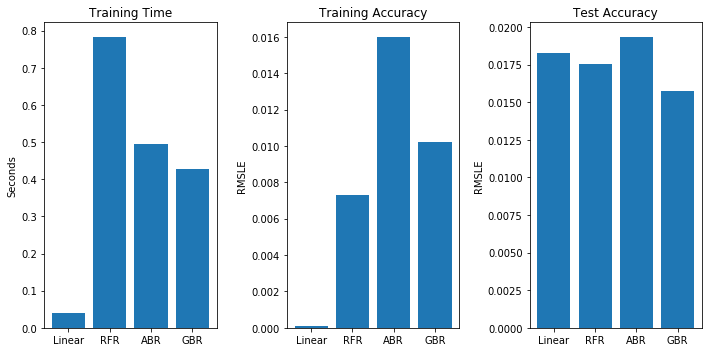

In [17]:
# Testing and Selecting Base Models: Visualize Test Results
fig,ax = plt.subplots(figsize=(10,5))
names = ['Linear','RFR','ABR','GBR']
titles = ['Training Time','Training Accuracy','Test Accuracy']
y_titles = ['Seconds','RMSLE','RMSLE']
plot_info = zip(titles,y_titles)

for i,titles in enumerate(plot_info):
    plt.subplot(1,3,i+1)
    plt.bar(x=names,height=results[:,i])
    plt.title(titles[0])
    plt.ylabel(titles[1])
    
plt.tight_layout()
plt.show()

It is apparent, that the linear model takes very little training time and fits the training set with near perfection. However, it seems, that the linear model has the greatest difficulties in generalizing to the test. As time is not too much of a concern in this application, it is the right choice to go for the best model, i.e. the GradientBoostRegressor.

In [18]:
# Finetuning of the best model: Grid Search Cross Validation
param_grid = {'GradientBoosting__loss':['ls','lad','huber'],
              'GradientBoosting__learning_rate':np.linspace(0.0001,0.01,4),
              'GradientBoosting__n_estimators':np.linspace(10,1500,10).astype('int'),
              'GradientBoosting__max_depth':[3,5,10]}

rmsle_scorer = make_scorer(rmsle,greater_is_better=True)

grad_boost_pipe_cv = GridSearchCV(estimator=grad_boost_pipe,param_grid=param_grid,scoring=rmsle_scorer,n_jobs=-1)

In [9]:
# Finetuning of the best model: Fit final model
grad_boost_pipe_cv.fit(X_train,y_train)

final_results = test_model(grad_boost_pipe_cv)

print(final_results)

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [19]:
# yhat = grad_boost_pipe_cv.predict(X_test)
# residuals = y_test - yhat
# sns.distplot(a=residuals)
# print(np.mean(residuals))
# print(np.std(residuals))
# print(skew(residuals))
# print(kurtosis(residuals))
print(results)

[[3.99450000e-02 1.15306331e-04 1.82813241e-02]
 [7.82979000e-01 7.28488716e-03 1.75253051e-02]
 [4.95336000e-01 1.59949699e-02 1.93418363e-02]
 [4.27402000e-01 1.02134999e-02 1.57281713e-02]]
